**Unzip the uploaded data files**

In [1]:
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# End-to-end multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.5.0 and TensorFlow Hub.

## 1. Problem
Identifing the breed of dog using a given image of the dog.
When I'm sitting in a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data that we are using is from Kaggle's Dog Breed Identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data), so it's probably best we use Deep Learning / Transfer Learning.
* There are 120 breeds of dogs (This means there are 120 different classes.
* There are around 10,000+ images in the training set (These images have labels).
* There around 10,000+ images in the test set (these images will have no labels, because we want to predict them).



# Get our workspace ready

* Import TensorFLow
* Import TensorFlow Hub
* Make sure we'e using a GPU

In [2]:
# Import TensorFlow in Colab
import tensorflow as tf
print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.5.0


In [3]:
# Import TensorFlow Hub
import tensorflow_hub as hub
print("TensorFlow Hub Version: " + hub.__version__)

TensorFlow Hub Version: 0.12.0


In [4]:
# Check for GPU availability
# https://research.google.com/colaboratory/faq.html#gpu-availability
print("GPU", " available (YESS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU  available (YESS!!!!!)


In [5]:
# Change Runtime Type to GPU
# Go to Runtime -> Chage Runtime Type -> Select GPU and save

## Getting our data read (turning it into tensors)

With all machine learning models our data has to be in numerical format. So that's what we'll be doing first. Turning our images into tensors (numerical representations).

Let's start by accessing our data and checking out the labes.

In [6]:
# Check out the labels of our data
import pandas as pd
import numpy as np

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     bb85276dbd61f284f520733f76e96b3b  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


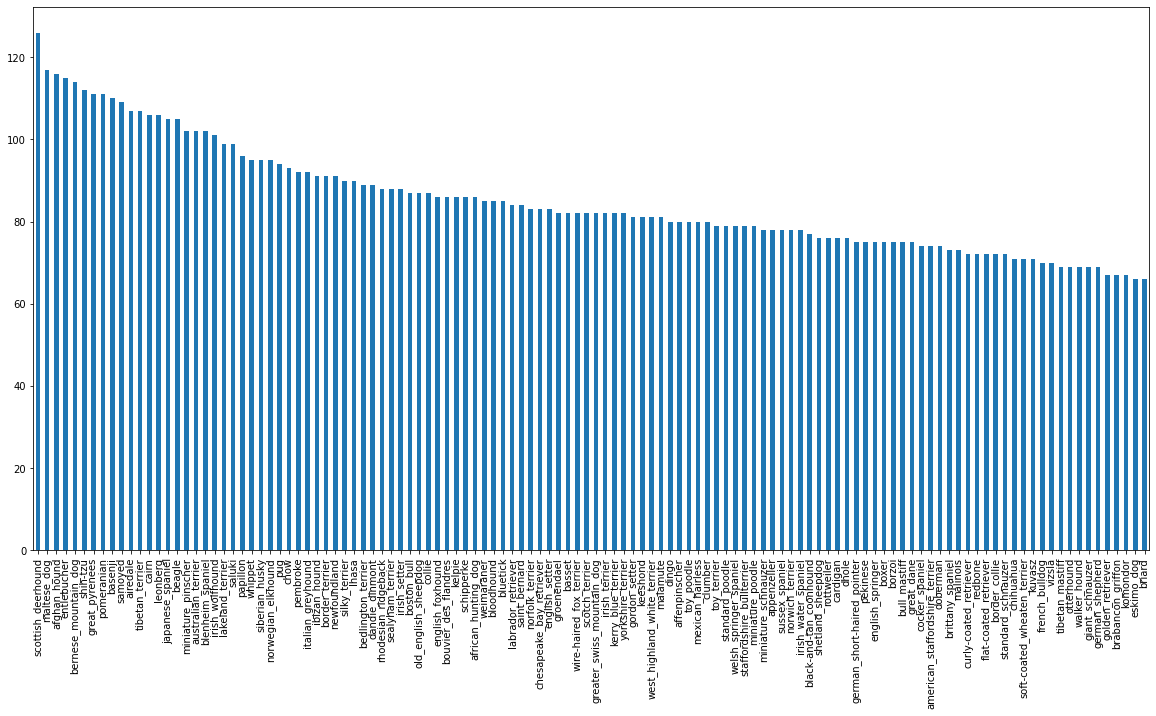

In [7]:
# How many images are there of each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [8]:
# Check the median
labels_csv["breed"].value_counts().median() 

82.0

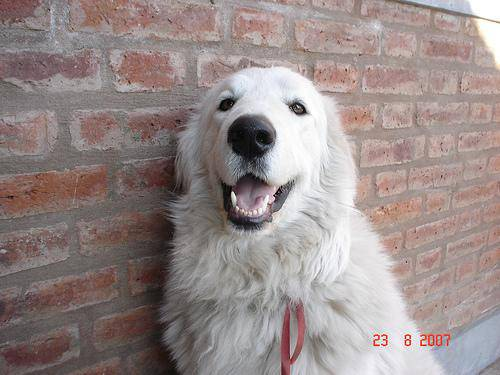

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/0a0c223352985ec154fd604d7ddceabd.jpg")

### Getting images and their labels

Let's get a list of all of our images pathnames.

In [10]:
# Create pathnames from images ID's in labels_csv data frame
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train")) == len(filenames):
  print("Filenames match the actual amount of files!!! Procceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match the actual amount of files!!! Procceed.


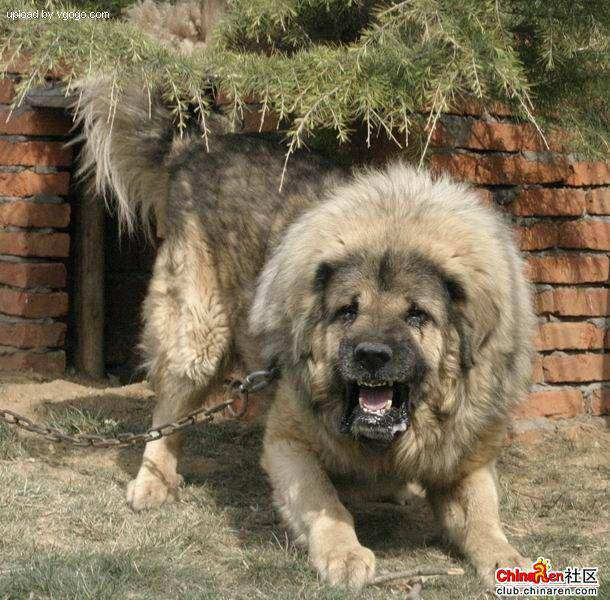

In [12]:
# View some random index image
Image(filenames[9000])

In [13]:
# Check the breed of dog at 9000 index
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training images filepaths in a list, let's prepare our labels

In [14]:
labels = np.array(labels_csv["breed"])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches with number of filenames!!")
else:
  print("Number of labels doesn't match with number of filenames. Check data directories")

Number of labels matches with number of filenames!!


### Turn our data labels into numbers

In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
len(unique_breeds)

120

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into an array of booleans
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Turning boolean array in intergers
print(labels[0]) # Origin
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we are going to create our own.

In [23]:
# Setup X and Y variables
X = filenames
Y = boolean_labels

We are going to start experimenting with ~1000 images and increase as needed.

In [24]:
# Set the number of images to use for experimenting by ceating a slider param using Colab
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [25]:
# Let's split our data into train and test
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, Y_train, Y_val = train_test_split(X[:NUM_IMAGES], 
                                                  Y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(Y_train), len(X_val), len(Y_val)

(800, 800, 200, 200)

In [26]:
len(boolean_labels)

10222

In [27]:
# Let's have a geez at the training data
X_train[:5], Y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing Images (turning images into tensors)

To pre-process our images into the Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use the TensorFlow to read the file and save it to a vaiable 'image'
3. Turn our 'image' (a JPG) into Tensors
4. Normalize our image (convert color channel values 0-255 to 0-1)
5. Resize the 'image' to be a shape of (224, 224)
6. Return the modified 'image'

TensorFlow Data Loading: https://www.tensorflow.org/tutorials/load_data/images

Before we do, let's see what importing an image looks like

In [28]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

Check colour channel in image

In [29]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [30]:
image.max()

255

In [31]:
# Convert image NumPy array into Tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen how an image looks like a tensor, let's create a function to preprocess them.

In [32]:
# Define image size
IMG_SIZE = 224
# Create a fuction for pre-proccessing images
def process_image(image_path, image_size=IMG_SIZE):
  """
  Take an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the JPG image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 (Normalization) 
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired shape that is (224, 224)
  image = tf.image.resize(image, size=[image_size, image_size])
  return image

In [33]:
process_image(filenames[32])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[2.1821149e-02, 9.6624352e-02, 3.9579429e-02],
        [3.1774971e-01, 3.9849764e-01, 3.4007537e-01],
        [1.9432701e-02, 7.9156667e-02, 2.5785400e-02],
        ...,
        [0.0000000e+00, 2.8685225e-02, 7.3815696e-03],
        [1.9170513e-03, 4.3444425e-02, 1.0881329e-02],
        [1.4592139e-02, 6.1650965e-02, 2.2435278e-02]],

       [[1.0875124e-01, 1.8718261e-01, 1.4012378e-01],
        [1.7272735e-04, 4.8262980e-02, 1.3897762e-03],
        [6.4935260e-02, 1.2673499e-01, 8.3912849e-02],
        ...,
        [1.0160362e-04, 1.2352975e-02, 9.8086741e-05],
        [1.2390460e-02, 5.1494777e-02, 2.0159349e-02],
        [2.1063086e-02, 6.0197882e-02, 2.8852297e-02]],

       [[5.7045318e-02, 1.2597509e-01, 7.8916252e-02],
        [1.0413458e-02, 6.4111114e-02, 2.4974126e-02],
        [1.2249038e-02, 6.4907044e-02, 2.5636028e-02],
        ...,
        [2.1364415e-02, 4.3656677e-02, 1.5458719e-02],
        [1.4683082e-02

### Turning our data into batches

Why turn our data into batches?
Let's say you're trying to process 10000+ images in one go.... They all might not fit into the memory

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which looks like this:
'(image, label)'

In [34]:
# Create a simple function to return a tuple of Tensor (image, label)
def get_image_label(image_path, label):
  """
  Take an image file path and the associated label,
  proccesses the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [35]:
# Demo of the above function
get_image_label(X[42], tf.constant(Y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form '(image, label)', let's make a function to turn all of our data ('X' and 'Y') into batches.

In [41]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to data into batches
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create the batches of data out of image (X) and label (Y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts Test Data as input (no labels).
  """
  # If the data is test data set we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # Only filepaths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch 
  # If the data is a valid data set, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y))) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  # It means this is a training batch
  else:
    print("Creating training data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y)))
    # Shuffle the pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a pre-proccessed image) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [42]:
# Create training and validation data batches
train_data = create_data_batches(X_train, Y_train)
val_data = create_data_batches(X_val, Y_val, valid_data=True)

Creating training data batches....
Creating validation data batches....


In [43]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))